### Environment Setup

The `contractions` package is download required, which is not available by default in Google Colab. Other libraries (e.g., NLTK, scikit-learn, Transformers) are preinstalled


In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.8 MB/s eta 0:00:00


### Library Imports

All necessary libraries for text preprocessing, data handling, model training, and evaluation are imported. This ensures single runnable file.


In [2]:
import os
import contractions
import html
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re

from bs4 import BeautifulSoup
from google.colab import drive

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import ParameterGrid

from transformers import BertTokenizer, BertModel
import torch


In [3]:
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Reproducibility

Setting up global NumPy seed acording to my `student_id` (2412240) to ensure all randomness is reproducible as required.


In [4]:
student_id = 2412240

In [5]:
# Numpy seed
np.random.seed(student_id)

In [6]:
# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [7]:
# Add your code to initialize GDrive and data and models paths

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "./CE807-25-SU/Assignment/"
GOOGLE_DRIVE_PATH = os.path.join("drive", "MyDrive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print("List files: ", os.listdir(GOOGLE_DRIVE_PATH))

List files:  ['data', 'model', 'code.ipynb']


In [8]:
DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, "data", "32")
train_file = os.path.join(DATA_PATH, "train.csv")
print("Train file: ", train_file)

val_file = os.path.join(DATA_PATH, "valid.csv")
print("Validation file: ", val_file)

test_file = os.path.join(DATA_PATH, "test.csv")
print("Test file: ", test_file)


Train file:  drive/MyDrive/./CE807-25-SU/Assignment/data/32/train.csv
Validation file:  drive/MyDrive/./CE807-25-SU/Assignment/data/32/valid.csv
Test file:  drive/MyDrive/./CE807-25-SU/Assignment/data/32/test.csv


In [9]:
train_df = pd.read_csv(train_file)
valid_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

In [10]:
MODEL_PATH_1 = os.path.join(GOOGLE_DRIVE_PATH, "model", str(student_id), "model_1")
os.makedirs(MODEL_PATH_1, exist_ok=True)

MODEL_PATH_2 = os.path.join(GOOGLE_DRIVE_PATH, "model", str(student_id), "model_2")
os.makedirs(MODEL_PATH_2, exist_ok=True)


In [11]:
train_df.head()

,id,data_id,text,rating
0,118544,32,"need better instructions to install, filter is...",4
1,110394,32,These were the thickest and largest i have bee...,5
2,191744,32,Love this Dirty/Clean magnet for my dishwasher...,5
3,302273,32,Works as described. Recommend this product to...,4
4,192229,32,Filters work just fine. No problems or issues ...,5


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4914 entries, 0 to 4913
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       4914 non-null   int64 
 1   data_id  4914 non-null   int64 
 2   text     4914 non-null   object
 3   rating   4914 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 153.7+ KB


In [13]:
train_df.describe()

,id,data_id,rating
count,4914.000000,4914.0,4914.000000
mean,353379.880138,32.0,4.108262
std,201355.640383,0.0,1.452022
min,1.000000,32.0,1.000000
25%,182260.500000,32.0,4.000000
50%,354490.000000,32.0,5.000000
75%,528110.500000,32.0,5.000000
max,699985.000000,32.0,5.000000


### Class Imbalance Observation

A histogram of the `rating` column reveals a strong class imbalance, with rating 5 dominating. This indicate that we should use `class_weight='balanced'` in logistic regression to handle data.


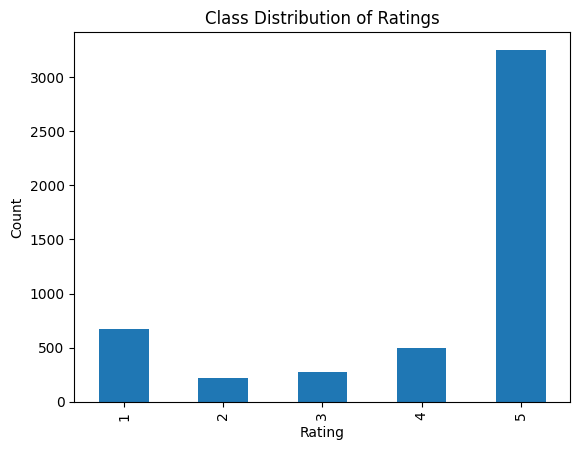

In [14]:
train_df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Class Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [15]:
train_df["word_count"] = train_df["text"].apply(lambda x: len(x.split()))
train_df["word_count"].describe()


,word_count
count,4914.000000
mean,38.966015
std,51.520637
min,6.000000
25%,12.000000
50%,23.000000
75%,44.750000
max,827.000000


### Stopword Distribution Analysis

We calculate the number of stopwords in each review to understand low-information content. This led the decision to remove stopwords during traditional preprocessing to enhance model focus.


In [16]:
stop_words = set(stopwords.words("english"))

def count_stopwords(text):
    tokens = word_tokenize(text.lower())
    return sum(1 for word in tokens if word in stop_words)

train_df["stopword_count"] = train_df["text"].apply(count_stopwords)
train_df["stopword_count"].describe()


,stopword_count
count,4914.000000
mean,19.164835
std,26.437929
min,0.000000
25%,5.000000
50%,11.000000
75%,23.000000
max,423.000000


### Custom Preprocessing Justification

This pipeline is designed for traditional ML models (TF-IDF + LR). It removes HTML, expands contractions, lowercases, strips punctuation and digits, and performs tokenization, stopword removal, and lemmatization. We use lemmatization instead of stemming to preserve word meaning, which improves model interpretability for TF-IDF.


In [17]:
# Initialize stopword list and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags (e.g. <br>)
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")

    # Expand contractions (e.g. don't ==> do not)
    text = contractions.fix(text)

    # Lowercase the text
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)

    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin and normalize whitespace
    return " ".join(tokens).strip()


In [18]:
def read_data(path):
    df = pd.read_csv(path)
    df["text"] = df["text"].astype(str)
    print(path, "has", len(df), "data points")
    return df


### Training Justification for TF-IDF + Logistic Regression

This function implements a traditional text classification pipeline using TF-IDF vectorization and Logistic Regression. We apply grid search over hyperparameters including `ngram_range`, `min_df`, `C`, and `solver` to systematically explore model configurations because without it the model accuracy was very low. And the TF-IDF representation is chosen for its sparse and interpretable features that align well with linear classifiers. To address the observed class imbalance, `class_weight='balanced'` is used during training. Validation performance is evaluated using weighted F1-score to ensure fairness across all rating classes, and the best model and vectorizer are saved for later use.


In [19]:
def train_1(train_file, val_file, model_dir):
    print("Training Method 1 (TF-IDF + Logistic Regression) with Grid Search...")
    train_df = read_data(train_file)
    valid_df = read_data(val_file)

    train_df["clean_text"] = train_df["text"].apply(preprocess)
    valid_df["clean_text"] = valid_df["text"].apply(preprocess)

    param_grid = {
        "ngram_range": [(1, 1), (1, 2)],
        "min_df": [1, 3],
        "C": [0.01, 0.1, 1, 10],
        "solver": ["lbfgs", "liblinear"],
    }

    best_f1 = 0
    best_params = None

    print("Grid searching...")
    for params in ParameterGrid(param_grid):
        vectorizer = TfidfVectorizer(
            ngram_range=params["ngram_range"],
            stop_words="english",
            min_df=params["min_df"],
        )
        X_train = vectorizer.fit_transform(train_df["clean_text"])
        X_valid = vectorizer.transform(valid_df["clean_text"])

        clf = LogisticRegression(
            C=params["C"],
            solver=params["solver"],
            class_weight="balanced",
            random_state=student_id,
            max_iter=1000,
        )
        clf.fit(X_train, train_df["rating"])
        preds = clf.predict(X_valid)
        f1 = f1_score(valid_df["rating"], preds, average="weighted")

        print(f"Params: {params}, F1: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params
            best_model = clf
            best_vectorizer = vectorizer

    print("\n Grid Search Complete.")
    print("\nBest Params:", best_params)
    print("Best F1 Score:", best_f1)

    # Final evaluation on validation set using best model
    X_val_best = best_vectorizer.transform(valid_df["clean_text"])
    y_val = valid_df["rating"]
    val_preds = best_model.predict(X_val_best)

    print("\nClassification Report for Best Model (TF-IDF + LR):")
    print(classification_report(y_val, val_preds, labels=[1, 2, 3, 4, 5]))

    val_acc = accuracy_score(y_val, val_preds)
    print(f"Validation Accuracy: {val_acc:.4f}")

    model_file = os.path.join(model_dir, "model.sav")
    pickle.dump(best_model, open(model_file, "wb"))
    print("Saved model to", model_file)

    vocab_file = os.path.join(model_dir, "vocab.sav")
    pickle.dump(best_vectorizer, open(vocab_file, "wb"))
    print("Saved vocab to", vocab_file)


In [20]:
def test_1(test_file, model_dir):
    test_df = read_data(test_file)
    test_df["clean_text"] = test_df["text"].apply(preprocess)

    model_file = os.path.join(model_dir, "model.sav")
    classifier = pickle.load(open(model_file, "rb"))
    print("Model loaded from", model_file)

    vocab_file = os.path.join(model_dir, "vocab.sav")
    tfidf_vectorizer = pickle.load(open(vocab_file, "rb"))
    print("Vocab loaded from", vocab_file)

    X_test = tfidf_vectorizer.transform(test_df["clean_text"])
    predictions = classifier.predict(X_test)

    test_df["out_label_model_1"] = predictions
    test_df.to_csv(test_file, index=False)
    print("Saved output to", test_file)


In [21]:
train_1(train_file, val_file, MODEL_PATH_1)
test_1(test_file, MODEL_PATH_1)


Training Method 1 (TF-IDF + Logistic Regression) with Grid Search...
drive/MyDrive/./CE807-25-SU/Assignment/data/32/train.csv has 4914 data points
drive/MyDrive/./CE807-25-SU/Assignment/data/32/valid.csv has 700 data points
Grid searching...
Params: {'C': 0.01, 'min_df': 1, 'ngram_range': (1, 1), 'solver': 'lbfgs'}, F1: 0.5880
Params: {'C': 0.01, 'min_df': 1, 'ngram_range': (1, 1), 'solver': 'liblinear'}, F1: 0.5266
Params: {'C': 0.01, 'min_df': 1, 'ngram_range': (1, 2), 'solver': 'lbfgs'}, F1: 0.6190
Params: {'C': 0.01, 'min_df': 1, 'ngram_range': (1, 2), 'solver': 'liblinear'}, F1: 0.5266
Params: {'C': 0.01, 'min_df': 3, 'ngram_range': (1, 1), 'solver': 'lbfgs'}, F1: 0.5894
Params: {'C': 0.01, 'min_df': 3, 'ngram_range': (1, 1), 'solver': 'liblinear'}, F1: 0.5266
Params: {'C': 0.01, 'min_df': 3, 'ngram_range': (1, 2), 'solver': 'lbfgs'}, F1: 0.5914
Params: {'C': 0.01, 'min_df': 3, 'ngram_range': (1, 2), 'solver': 'liblinear'}, F1: 0.5266
Params: {'C': 0.1, 'min_df': 1, 'ngram_range':

In [22]:
def get_bert_cls_embeddings(texts, tokenizer, bert_model, max_len=128, batch_size=32, device="cuda"):
    embeddings = []
    bert_model.eval()
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        encodings = tokenizer(
            batch_texts,
            truncation=True,
            padding="max_length",
            max_length=max_len,
            return_tensors="pt",
        )
        input_ids = encodings["input_ids"].to(device)
        attention_mask = encodings["attention_mask"].to(device)
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            batch_embeds = outputs.pooler_output
        embeddings.append(batch_embeds.cpu().numpy())
    return np.vstack(embeddings)

### Training Justification for BERT + Logistic Regression

This function implements the second model using BERT-based contextual embeddings combined with Logistic Regression. For BERT we didn't do text preprocessing because BERT already know how to work without pre processed text. The pre-trained BERT model (`bert-base-uncased`) is used to extract `[CLS]` token embeddings, which capture the semantic meaning of entire reviews. We perform grid search over `C`, `solver`, and `class_weight` to select the best logistic regression configuration based on weighted F1-score on the validation set. Before this Grid search it was not performing well. It give lower score than traditioanl tokenization. So we included hyperparameter tuning. So, This approach meets the best for using deep contextualized tokenization and representation, while also handling class imbalance and ensuring model performance is optimized through validation.


In [23]:
def train_2(train_file, val_file, model_dir):
    print("Training Method 2 (BERT + Logistic Regression) with Grid Search...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("💻 Using device:", device)

    # Load BERT model/tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

    # Read data
    train_df = read_data(train_file)
    val_df = read_data(val_file)
    train_texts = train_df["text"].astype(str).tolist()
    val_texts = val_df["text"].astype(str).tolist()
    y_train = train_df["rating"].values
    y_val = val_df["rating"].values

    # Extract BERT [CLS] features
    print("Extracting BERT [CLS] features for training set...")
    X_train = get_bert_cls_embeddings(train_texts, tokenizer, bert_model, device=device)
    print("Extracting BERT [CLS] features for validation set...")
    X_val = get_bert_cls_embeddings(val_texts, tokenizer, bert_model, device=device)

    # Hyperparameter grid
    param_grid = {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["lbfgs", "liblinear", "saga"],
        "class_weight": ["balanced"],
    }

    best_f1 = 0
    best_params = None
    best_model = None

    print("\nStarting Grid Search...")
    for params in ParameterGrid(param_grid):
        clf = LogisticRegression(
            C=params["C"],
            solver=params["solver"],
            class_weight=params["class_weight"],
            random_state=student_id,
            max_iter=5000,
        )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred, average="weighted")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params
            best_model = clf

    # Print only the best model's metrics which important for report
    print("\n Grid Search Complete.")
    print("Best Params:", best_params)
    print("Best Weighted F1:", best_f1)
    y_pred_best = best_model.predict(X_val)
    print("\nClassification Report for Best Model:\n", classification_report(y_val, y_pred_best))
    print("Best Validation Accuracy:", accuracy_score(y_val, y_pred_best))

    # Save the best model and BERT/tokenizer
    os.makedirs(model_dir, exist_ok=True)
    model_file = os.path.join(model_dir, "model.sav")
    pickle.dump(best_model, open(model_file, "wb"))
    print("Saved model to", model_dir)


In [24]:
def test_2(test_file, model_dir):
    print("Testing Method 2 (BERT + Logistic Regression)...")
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load BERT tokenizer and model from pretrained checkpoint
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

    # Load trained classifier
    model_file = os.path.join(model_dir, "model.sav")
    clf = pickle.load(open(model_file, "rb"))
    print("Model loaded from", model_file)

    # Read and embed test data
    test_df = read_data(test_file)
    test_texts = test_df["text"].astype(str).tolist()
    print("Extracting BERT [CLS] features for test set...")
    X_test = get_bert_cls_embeddings(test_texts, tokenizer, bert_model, device=device)

    # Predict and write output
    y_pred = clf.predict(X_test)
    test_df["out_label_model_2"] = y_pred
    test_df.to_csv(test_file, index=False)
    print(f"Saved predictions to {test_file}")

In [25]:
train_2(train_file, val_file, MODEL_PATH_2)
test_2(test_file, MODEL_PATH_2)


Training Method 2 (BERT + Logistic Regression) with Grid Search...
💻 Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

drive/MyDrive/./CE807-25-SU/Assignment/data/32/train.csv has 4914 data points
drive/MyDrive/./CE807-25-SU/Assignment/data/32/valid.csv has 700 data points
Extracting BERT [CLS] features for training set...
Extracting BERT [CLS] features for validation set...

Starting Grid Search...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Grid Search Complete.
Best Params: {'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best Weighted F1: 0.686375783954497

Classification Report for Best Model:
               precision    recall  f1-score   support

           1       0.66      0.64      0.65        96
           2       0.11      0.13      0.12        31
           3       0.23      0.26      0.24        39
           4       0.17      0.11      0.13        71
           5       0.84      0.87      0.85       463

    accuracy                           0.69       700
   macro avg       0.40      0.40      0.40       700
weighted avg       0.68      0.69      0.69       700

Best Validation Accuracy: 0.6942857142857143
Saved model to drive/MyDrive/./CE807-25-SU/Assignment/model/2412240/model_2
Testing Method 2 (BERT + Logistic Regression)...
Model loaded from drive/MyDrive/./CE807-25-SU/Assignment/model/2412240/model_2/model.sav
drive/MyDrive/./CE807-25-SU/Assignment/data/32/test.csv has 1386 data points
Ex